# 국민청원 데이터로 청원 카테고리 분류하기
* 청와대 국민청원 : https://www1.president.go.kr/petitions

> 학습세트의 카테고리를 바탕으로 테스트 세트의 청원 카테고리를 분류해 봅니다.

1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 데이터 전처리
1. 단어 벡터화(BOW, TF-IDF)
1. 분류기 설정하기(Random Forest)
1. 분류기로 학습시키기
1. 학습의 정확도 보기
1. 테스트 데이터 예측하기
1. 실제 데이터와 예측결과의 차이를 보기

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(377756, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [4]:
# 전체 데이터 중 투표가 500건 이상인 데이터를 기준으로 가져옵니다.
df = petitions.loc[(petitions['votes'] > 500)].copy()
df.shape

(5186, 8)

In [5]:
df.describe()

,article_id,answered,votes
count,5186.000000,5186.000000,5.186000e+03
mean,252276.849402,0.005592,9.774535e+03
std,137525.114775,0.074577,4.018005e+04
min,28.000000,0.000000,5.010000e+02
25%,145303.500000,0.000000,7.760000e+02
50%,242531.000000,0.000000,1.491000e+03
75%,375185.000000,0.000000,3.991000e+03
max,491954.000000,1.000000,1.192049e+06


In [6]:
category_count = df['category'].value_counts()
category_count

인권/성평등         680
육아/교육          589
안전/환경          509
교통/건축/국토       481
보건복지           476
정치개혁           453
기타             419
문화/예술/체육/언론    296
행정             253
외교/통일/국방       248
일자리            242
경제민주화          184
반려동물           150
미래              80
성장동력            50
저출산/고령화대책       42
농산어촌            34
Name: category, dtype: int64

In [7]:
len(df['category'].unique())

17

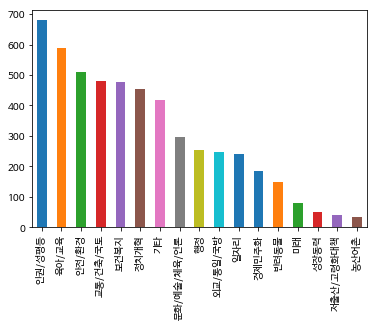

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

# 나눔 바른고딕이 설치되어 있어야 합니다.
# 해당 폰트가 없다면 설치된 폰트명으로 지정해 주어야 합니다.
plt.rcParams["font.family"] = 'NanumBarunGothic'
category_count.plot(kind='bar')

(2018, 8)


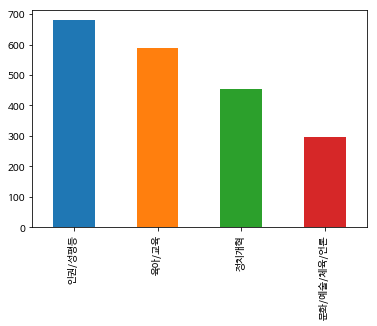

In [9]:
df = df[(df['category'] == '인권/성평등') | 
        (df['category'] == '육아/교육') | 
        (df['category'] == '문화/예술/체육/언론') | 
        (df['category'] == '정치개혁')]

print(df.shape)
category_count = df['category'].value_counts()
category_count
category_count.plot(kind='bar')

In [10]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [11]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
46,69,2017-08-20,2017-09-04,0,4934,육아/교육,"영어전문강사, 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합니다",저는 30대 초반에 수능 다시 공부해서 교대에 다니고 있는 교대생입니다. 회사에 다...,육아/교육
48,71,2017-08-20,2017-09-19,0,4484,육아/교육,"영양 교사 폐지, 영양직 직렬 신설을 청원합니다.",대통령님께서 대선 후보이시던 시절 충격적인 기사를 접했습니다. 영양사 단체 행사에서...,육아/교육
51,74,2017-08-20,2017-11-18,0,520,육아/교육,기간제 교사 정규직화 결사 반대,안녕하세요 대통령님. 저는 중등임용 국어과목을 준비하고 있는 예비교사입니다.\n올해...,육아/교육


In [12]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0].name
sample_index

21

In [13]:
sample_title = df.loc[sample_index, 'title']
sample_title

'기간제 교사의 정규직화를 반대합니다.'

In [14]:
sample_content = petitions['content'][sample_index]
sample_content

'대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된다고 했을 때, 공채 채용과정이 있는데, 설마 그러겠어라고 생각하고 있었습니다. 그리고 기간제는 그 채용과정이 공개채용에 비해 불투명하고, 아이들을 가르칠 수 있는 전문성이 떨어지는데, 어떻게 된다는 거지? 그런 생각이라 사실 그냥 뜬 소문이라고 생각했습니다.\\n수년간 임용을 준비하는 수험생으로서, 여러 기회비용을 포기하고, 오로지 교단에서 서서 아이들에게 내가 알고 있는 지식을 제대로 가르치겠다는 신념으로 공부해왔습니다. 그런데 오늘 보니 기간제가 정규직화되는 것이 거의 확정적으로 되는 것같아, 사실 너무 상대적 허탈감을 느낍니다. 기간제 선생님들은 임용고시를 일단 보류해두고 현장에 나아간 것이고, 임용 준비생은 일단 임용고시 합격을 목표로 그 한해 기회비용까지 써가면서 공부하는 것이니까요. 그래서 전문적인 지식을 더 갖추고 있는 임용수험생들이 현장에 일하지 않았다는 이유로 기간제 교사에게 기회까지 박탈당하면서 자리를 내주어야 하나 의구심이 듭니다. 존경하는 대통령님 기간제 정규직화 다시 한번 생각해주시기 바랍니다. 양질의 아이들에게 교육을 제공하기 위해서라도, 기간제 정규직화는 안됩니다. 똑같은 기회의 평등을 제공해주십시오. 전문적인 지식을 갖추고 열심히 노력한 임고생이 단지 현장을 경험하지 않았다는 이유만으로 역차별을 당하는 일은 없어야 합니다. 미래의 아이들을 가르칠 인력, 다시 한번 심사숙고해주시길 바랍니다. 나라를 이끌어갈 인재를 양성하는 곳입니다.\\n제발, 다시한번 시사숙고 해주시길 바랍니다.\\n그리고 사대와 교대를 폐지하고 로스쿨화시킨다고 글을 카페에서 읽었습니다. 제발 사실이 아니길 기도합니다. 현대판 음서제를 시행하는 것이라고 비판하더라군요. 또한 교육개혁에 교사의 지방직화라는 글을 들었습니다. 처음에는 그냥 설마겠거니 했습니다. 그런데 점차그렇게 흘러가는 것 같더군요. 나라의 재정이 어려워, 공무원 연금을 삭감하기 위해 기간제를 무기계약직으로 채용하는 

# 전처리 하기 
* 특수문자 제거
* 개행문자 제거
* 불용어 처리

In [15]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [16]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

## 샘플데이터에 먼저 적용해 보기

In [17]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [18]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [19]:
pre_sample_content

'대통령님  안녕하세요  임용을 준비하고 수험생입니다  처음 기간제 정규직화 된다고 했을 때  공채 채용과정이 있는데  설마 그러겠어라고 생각하고 있었습니다  기간제는 채용과정이 공개채용에 비해 불투명하고  아이들을 가르칠 전문성이 떨어지는데  어떻게 된다는 거지  그런 생각이라 사실 그냥 뜬 소문이라고 생각했습니다  수년간 임용을 준비하는 수험생으로서  여러 기회비용을 포기하고  오로지 교단에서 서서 아이들에게 내가 알고 지식을 제대로 가르치겠다는 신념으로 공부해왔습니다  그런데 오늘 보니 기간제가 정규직화되는 것이 거의 확정적으로 되는 것같아  사실 너무 상대적 허탈감을 느낍니다  기간제 선생님들은 임용고시를 일단 보류해두고 현장에 나아간 것이고  임용 준비생은 일단 임용고시 합격을 목표로 한해 기회비용까지 써가면서 공부하는 것이니까요  그래서 전문적인 지식을 갖추고 임용수험생들이 현장에 일하지 않았다는 이유로 기간제 교사에게 기회까지 박탈당하면서 자리를 내주어야 하나 의구심이 듭니다  존경하는 대통령님 기간제 정규직화 다시 한번 생각해주시기 바랍니다  양질의 아이들에게 교육을 제공하기 위해서라도  기간제 정규직화는 안됩니다  똑같은 기회의 평등을 제공해주십시오  전문적인 지식을 갖추고 열심히 노력한 임고생이 단지 현장을 경험하지 않았다는 이유만으로 역차별을 당하는 일은 없어야  미래의 아이들을 가르칠 인력  다시 한번 심사숙고해주시길 바랍니다  나라를 이끌어갈 인재를 양성하는 곳입니다  제발  다시한번 시사숙고 해주시길 바랍니다  사대와 교대를 폐지하고 로스쿨화시킨다고 글을 카페에서 읽었습니다  제발 사실이 아니길 기도합니다  현대판 음서제를 시행하는 것이라고 비판하더라군요  또한 교육개혁에 교사의 지방직화라는 글을 들었습니다  처음에는 그냥 설마겠거니 했습니다  그런데 점차그렇게 흘러가는 것 같더군요  나라의 재정이 어려워  공무원 연금을 삭감하기 기간제를 무기계약직으로 채용하는 것이라면  그게 시작이라면 어쩔 없다고 생각합니다  하지만 의원님  교육의

## 전체 데이터에 적용하기

In [20]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 267 ms, sys: 9.87 ms, total: 277 ms
Wall time: 318 ms


In [21]:
%time df['content_preprocessed'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 415 ms, sys: 7.72 ms, total: 422 ms
Wall time: 431 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [22]:
df = df.reindex()

In [23]:
df.shape

(2018, 11)

In [24]:
split_count = int(df.shape[0] * 0.7)
split_count

1412

In [25]:
df_train = df[:split_count].copy()
df_train.shape

(1412, 11)

In [26]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessed
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
46,69,2017-08-20,2017-09-04,0,4934,육아/교육,"영어전문강사, 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합니다",저는 30대 초반에 수능 다시 공부해서 교대에 다니고 있는 교대생입니다. 회사에 다...,육아/교육,저는 대 초반에 수능 다시 공부해서 교대에 다니고 있는 교대생입니다 회사에 다...,대 초반에 수능 다시 공부해서 교대에 다니고 교대생입니다 회사에 다니다 교사의...
48,71,2017-08-20,2017-09-19,0,4484,육아/교육,"영양 교사 폐지, 영양직 직렬 신설을 청원합니다.",대통령님께서 대선 후보이시던 시절 충격적인 기사를 접했습니다. 영양사 단체 행사에서...,육아/교육,대통령님께서 대선 후보이시던 시절 충격적인 기사를 접했습니다 영양사 단체 행사에서...,대통령님께서 대선 후보이시던 시절 충격적인 기사를 접했습니다 영양사 단체 행사에서...
51,74,2017-08-20,2017-11-18,0,520,육아/교육,기간제 교사 정규직화 결사 반대,안녕하세요 대통령님. 저는 중등임용 국어과목을 준비하고 있는 예비교사입니다.\n올해...,육아/교육,안녕하세요 대통령님 저는 중등임용 국어과목을 준비하고 있는 예비교사입니다 올해 ...,안녕하세요 대통령님 중등임용 국어과목을 준비하고 예비교사입니다 올해 처음으로 응...


In [27]:
df_test = df[split_count:].copy()
df_test.shape

(606, 11)

In [28]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessed
250850,325097,2018-07-31,2018-08-30,0,623,육아/교육,"교육공무직은 교사 보조를 위한 직업인데, 교사가 되려고, 공무원이 되려고 합니다. ...",교육공무직은 교사 보조를 위한 직업입니다.\n그러나 그동안 교육공무직은 여러 가지 ...,육아/교육,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...
251078,325394,2018-08-01,2018-08-31,0,760,정치개혁,문재인 대통령 탄핵 동의하시길 부탁드립니다,"남북 'DMZ 평화지대화' 큰틀 견해 일치…北 ""생산적 회담""\nGP시범철수·JSA...",정치개혁,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...
251174,325534,2018-08-01,2018-08-31,0,1009,인권/성평등,유관순 열사의 서훈등급의 승급을 요청합니다.,유관순 열사의 서훈등급의 승급을 요청합니다.\n유관순 열사는 3.1. 만세운동의 상...,인권/성평등,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...
251294,325691,2018-08-01,2018-08-31,0,1806,육아/교육,학교 행정실을 없애주세요.,1. 저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,육아/교육,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...
251315,325713,2018-08-01,2018-08-31,0,1419,인권/성평등,창원 출입국관리사무소 단속반원 징계 건의,"지난 7월 16일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여, 위법한 직...",인권/성평등,지난 월 일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직...,지난 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직무수행을...


# 카테고리
## 학습 세트의 카테고리 보기

In [29]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category= df_train_category_value.merge(df_train_category_percent, 
                                                 left_index=True, right_index=True)
df_train_category.columns = ['청원수', '청원비율']
df_train_category

,청원수,청원비율
인권/성평등,451,0.319405
육아/교육,375,0.265581
정치개혁,353,0.250000
문화/예술/체육/언론,233,0.165014


In [30]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category = df_test_category_value.merge(df_test_category_percent, 
                                                left_index=True, right_index=True)
df_test_category.columns = ['청원수', '청원비율']
df_test_category

,청원수,청원비율
인권/성평등,229,0.377888
육아/교육,214,0.353135
정치개혁,100,0.165017
문화/예술/체육/언론,63,0.103960


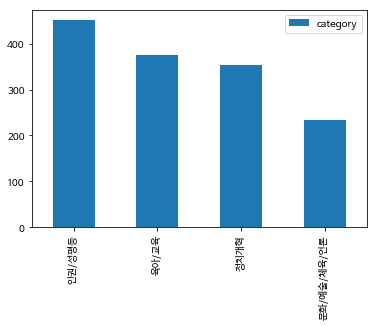

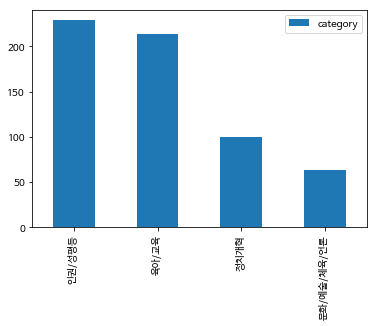

In [31]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

## BOW(Bag of Words)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', 
         '그', '년도', '합니다', '하는', '및', '제', '할', '하고', 
         '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', 
         '등', '일', '많은', '이런', '것은', 
         '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessed'])
train_feature_vector.shape

CPU times: user 3.63 s, sys: 159 ms, total: 3.79 s
Wall time: 3.82 s


In [34]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessed'])
test_feature_vector.shape

CPU times: user 2.11 s, sys: 88.3 ms, total: 2.2 s
Wall time: 2.24 s


In [35]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'articles',
 'articleview',
 'articleview idxno',
 'asp',
 'a는',
 'cctv',
 'cctv를',
 'co',
 'co kr']

In [36]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,articles,articleview,articleview idxno,asp,a는,cctv,cctv를,co,co kr,...,활동을,회사,회사는,후에,훨씬,힘든,힘들게,힘듭니다,힘을,힘이
0,66,41,41,24,30,28,36,39,125,123,...,23,30,22,51,33,67,44,21,43,38


## TF-IDF 로 가중치 적용하기

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 8.94 ms, sys: 2.52 ms, total: 11.5 ms
Wall time: 10.1 ms


In [39]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 5.37 ms, sys: 1.66 ms, total: 7.02 ms
Wall time: 5.38 ms


In [40]:
test_feature_tfidf.shape

(606, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [42]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.24 s, sys: 39.8 ms, total: 1.28 s
Wall time: 599 ms


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면,
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 70 ms, sys: 96.4 ms, total: 166 ms
Wall time: 4.04 s


array([0.63957597, 0.66431095, 0.62765957, 0.70212766, 0.71276596])

## Mean Absolute Error

In [44]:
round(np.mean(score)*100,2)

66.93

# 예측

In [45]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['육아/교육', '인권/성평등', '육아/교육'], dtype=object)

In [46]:
y_pred.shape

(606,)

In [47]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,육아/교육
1,인권/성평등
2,육아/교육
3,육아/교육
4,인권/성평등


In [48]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
output['category_pred'].value_counts()

육아/교육          245
인권/성평등         198
정치개혁           130
문화/예술/체육/언론     33
Name: category_pred, dtype: int64

In [49]:
df_test['category_pred'] = y_pred

## 예측결과 미리보기

In [50]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessed,pred_diff
250850,325097,2018-07-31,2018-08-30,0,623,육아/교육,"교육공무직은 교사 보조를 위한 직업인데, 교사가 되려고, 공무원이 되려고 합니다. ...",교육공무직은 교사 보조를 위한 직업입니다.\n그러나 그동안 교육공무직은 여러 가지 ...,육아/교육,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...,1
251078,325394,2018-08-01,2018-08-31,0,760,정치개혁,문재인 대통령 탄핵 동의하시길 부탁드립니다,"남북 'DMZ 평화지대화' 큰틀 견해 일치…北 ""생산적 회담""\nGP시범철수·JSA...",인권/성평등,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...,0
251174,325534,2018-08-01,2018-08-31,0,1009,인권/성평등,유관순 열사의 서훈등급의 승급을 요청합니다.,유관순 열사의 서훈등급의 승급을 요청합니다.\n유관순 열사는 3.1. 만세운동의 상...,육아/교육,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...,0
251294,325691,2018-08-01,2018-08-31,0,1806,육아/교육,학교 행정실을 없애주세요.,1. 저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,육아/교육,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,1
251315,325713,2018-08-01,2018-08-31,0,1419,인권/성평등,창원 출입국관리사무소 단속반원 징계 건의,"지난 7월 16일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여, 위법한 직...",인권/성평등,지난 월 일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직...,지난 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직무수행을...,1


In [51]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    327
1    279
Name: pred_diff, dtype: int64

In [52]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 606건의 데이터 중 279건 예측


In [53]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 46.03960396039604


In [54]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessed,pred_diff
250850,325097,2018-07-31,2018-08-30,0,623,육아/교육,"교육공무직은 교사 보조를 위한 직업인데, 교사가 되려고, 공무원이 되려고 합니다. ...",교육공무직은 교사 보조를 위한 직업입니다.\n그러나 그동안 교육공무직은 여러 가지 ...,육아/교육,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...,교육공무직은 교사 보조를 위한 직업입니다 그러나 그동안 교육공무직은 여러 가지 활...,1
251294,325691,2018-08-01,2018-08-31,0,1806,육아/교육,학교 행정실을 없애주세요.,1. 저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,육아/교육,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,저희들은 과거에 서무과에 근무하다가 중등 준교사시험에 합격해 평교사로 재직하다...,1
251315,325713,2018-08-01,2018-08-31,0,1419,인권/성평등,창원 출입국관리사무소 단속반원 징계 건의,"지난 7월 16일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여, 위법한 직...",인권/성평등,지난 월 일 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직...,지난 경남 함안에서 벌어진 외국인 유학생 폭행사건에 대하여 위법한 직무수행을...,1
251688,326234,2018-08-01,2018-08-31,0,1324,정치개혁,인도적체류를 없애주시고 불법체류자를 추방해주세요.,이번에 난민법폐지는 힘들다는 기사를 봤습니다.\n사실 우리의 문제는 난민뿐만이 아닙...,정치개혁,이번에 난민법폐지는 힘들다는 기사를 봤습니다 사실 우리의 문제는 난민뿐만이 아닙니...,이번에 난민법폐지는 힘들다는 기사를 봤습니다 사실 우리의 문제는 난민뿐만이 아닙니...,1
251727,326291,2018-08-01,2018-08-31,0,11684,정치개혁,드루킹 특검 30일 기간 연장 청원합니다.,어렵게 구성된 특검 측에선 사안이 복잡하고 다양한 만큼 특검 기간 연장을 요청했지만...,정치개혁,어렵게 구성된 특검 측에선 사안이 복잡하고 다양한 만큼 특검 기간 연장을 요청했지만...,어렵게 구성된 특검 측에선 사안이 복잡하고 다양한 만큼 특검 기간 연장을 요청했지만...,1


## 잘못 예측한 카테고리 보기

In [55]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessed,pred_diff
251078,325394,2018-08-01,2018-08-31,0,760,정치개혁,문재인 대통령 탄핵 동의하시길 부탁드립니다,"남북 'DMZ 평화지대화' 큰틀 견해 일치…北 ""생산적 회담""\nGP시범철수·JSA...",인권/성평등,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...,남북 DMZ 평화지대화 큰틀 견해 일치 생산적 회담 GP시범철수 JSA비...,0
251174,325534,2018-08-01,2018-08-31,0,1009,인권/성평등,유관순 열사의 서훈등급의 승급을 요청합니다.,유관순 열사의 서훈등급의 승급을 요청합니다.\n유관순 열사는 3.1. 만세운동의 상...,육아/교육,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...,유관순 열사의 서훈등급의 승급을 요청합니다 유관순 열사는 만세운동의 상징...,0
251927,326551,2018-08-01,2018-08-31,0,1554,인권/성평등,경찰수험생 성폭력 강사 처벌해주세요,공단기 에서 국사를 강의하는 전한길 강사의 게시판에 피해자가 도움을 요청한 글이 아...,육아/교육,공단기 에서 국사를 강의하는 전한길 강사의 게시판에 피해자가 도움을 요청한 글이 아...,공단기 에서 국사를 강의하는 전한길 강사의 게시판에 피해자가 도움을 요청한 글이 아...,0
252180,326899,2018-08-02,2018-09-01,0,812,인권/성평등,동성애와 동성결혼 합법화가 시행되지 않게해주세요,조국 대한민국의 윤리도덕이 정부 주도 하에 무너지는 것을 막기 위해서입니다. 이 청...,정치개혁,조국 대한민국의 윤리도덕이 정부 주도 하에 무너지는 것을 막기 위해서입니다 이 청...,조국 대한민국의 윤리도덕이 정부 주도 하에 무너지는 것을 막기 위해서입니다 이 청...,0
252591,327449,2018-08-02,2018-09-01,0,721,정치개혁,이재명의 지위를 이용한 사전선거운동 공정한수사촉구,2015 11월 경기도 선관위는 이재명의 '지위를 이용한 사전선거운동' 공직선거법 ...,인권/성평등,월 경기도 선관위는 이재명의 지위를 이용한 사전선거운동 공직선거법 ...,경기도 선관위는 이재명의 지위를 이용한 사전선거운동 공직선거법 위반...,0


In [56]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

인권/성평등         135
육아/교육           86
문화/예술/체육/언론     57
정치개혁            49
Name: category, dtype: int64

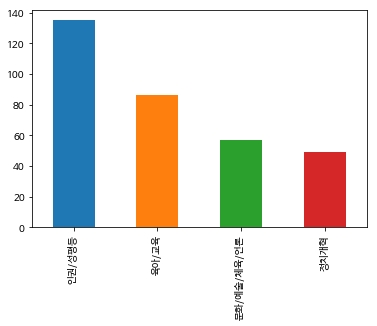

In [57]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [58]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
251078,정치개혁,인권/성평등,문재인 대통령 탄핵 동의하시길 부탁드립니다,"남북 'DMZ 평화지대화' 큰틀 견해 일치…北 ""생산적 회담""\nGP시범철수·JSA..."
251174,인권/성평등,육아/교육,유관순 열사의 서훈등급의 승급을 요청합니다.,유관순 열사의 서훈등급의 승급을 요청합니다.\n유관순 열사는 3.1. 만세운동의 상...
251927,인권/성평등,육아/교육,경찰수험생 성폭력 강사 처벌해주세요,공단기 에서 국사를 강의하는 전한길 강사의 게시판에 피해자가 도움을 요청한 글이 아...
252180,인권/성평등,정치개혁,동성애와 동성결혼 합법화가 시행되지 않게해주세요,조국 대한민국의 윤리도덕이 정부 주도 하에 무너지는 것을 막기 위해서입니다. 이 청...
252591,정치개혁,인권/성평등,이재명의 지위를 이용한 사전선거운동 공정한수사촉구,2015 11월 경기도 선관위는 이재명의 '지위를 이용한 사전선거운동' 공직선거법 ...
252935,정치개혁,육아/교육,자국민을 보호해주세요. 난민을 반대하는 목소리를 회피하지 말아주세요.,저는 중학교 3학년 빠른 년생 학생입니다. 저는 지루하고 따분한 정치에 관심도 없지...
253204,인권/성평등,정치개혁,중국동포!!! 조상님이 지어주신 한글이름을 돌려주세요,저는 출입국업무 대행을 하고 있는 행정사입니다.\n제가 행정사일을 하면서 알게된 중...
254267,인권/성평등,문화/예술/체육/언론,존경하는 민갑룡 경찰청장님께 드리는 말씀,안녕하십니까.\n이제는 공기처럼 당연하게만 느껴지는 세계적인 수준의 치안과 5천만 ...
254815,인권/성평등,정치개혁,존경하옵는 대통령님께 호소드립니다.,존경하옵는 대통령님께 호소드립니다.\n불철주야 늘 국민과 국가를 위해 헌신하시는 대...
255664,육아/교육,정치개혁,국민의 뜻 수시축소 정시확대 지켜주세요,투표결과 및 대다수의 국민이 정시확대를 요구하는데\n공론화및 2년넘게 추진 한것이...


## 원래 데이터 중 분류기가 다르게 예측한 특정 카테고리의 청원을 봅니다.

In [59]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '육아/교육'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
255664,육아/교육,정치개혁,국민의 뜻 수시축소 정시확대 지켜주세요,투표결과 및 대다수의 국민이 정시확대를 요구하는데\n공론화및 2년넘게 추진 한것이...
255881,육아/교육,인권/성평등,저희 사랑하는 아기가 믿었던 돌보미에 의해 학대당했습니다.,"""한국에 많은 맞벌이 부부, 젊은 부부들이 맘놓고 육아와 일을 할 수 있는 나라,\..."
256945,육아/교육,정치개혁,정부지원금 엄마에게 주세요,현재 보육정책은 0-2세 아이를 엄마가 집에서 키우면 20~10만원을 양육수당으로 ...
258983,육아/교육,정치개혁,숙명여고 교직원 자녀 2명이 이번에 동시에 전교1등 (문/이과)했다는데 부정 의혹을...,전교 50등 정도 하던 학생 두명이 현직 숙명여고 교직원 자녀들로서 이번 1학기 기...
259282,육아/교육,정치개혁,고등학교 교직원 자녀의 같은학교 배정금지,학생부종합을 비롯한 수시가 대세인 요즘.\n학생부의 중요성은 이루 말할수없습니다.\...
264152,육아/교육,인권/성평등,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,안녕하세요 저는 4세아들과7개월넘은 두아들을 키우고 잇습니다. 두아들이 다니는 어린...
267335,육아/교육,정치개혁,초등학생 중학생 등 미성년자의핸드폰중독으로 인한 불법사이트노출 교통사고등등 사회문제...,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록\n정부및 통신사에서\n도움 꼭 ...
268634,육아/교육,인권/성평등,초중등학교 내 스마트폰 사용 금지 청원,내년부터는 5-16세 학생이 학교에서 스마트폰을 사용하지 못하도록 하는 법안을 만들...
270428,육아/교육,인권/성평등,"〓 국민특명, 전국 초․중․고 즉각 휴교실시 〓",전국 초․중․고교의 교장님들!\n고리타분한 노인네 티내지 마시고 당장 내일부터 태풍...
274475,육아/교육,인권/성평등,제주 **초등학교 1학년 아이들이 학교폭력의 가해자가 되었습니다.,저희는 제주 ** 초등학교 1학년 학생을 자녀로 둔 학부모들입니다. 이제 막 1학년...


## 아래의 예측비율을 높여보세요. 
* 학습 세트와 테스트 세트의 비율을 7:3으로 유지하도록 하고 다음의 방법들을 사용해 볼 수 있습니다. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * 벡터 기법에 들어가는 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경

In [60]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('정답 예측 비율 {}'.format(acc))

정답 예측 비율 46.03960396039604
